In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import random
import os
import glob

In [5]:
# Load the dataset
chunk_size = 100000  
chunks = pd.read_csv('./data/dataset23.csv', chunksize=chunk_size)

data = pd.concat(chunks, ignore_index=True)


In [6]:
data.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,tcp,-,2.999051,0,...,S0,-,-,0,S,3,180,0,0,(empty) Malicious PartOfAHorizontalPortScan
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,-,-,-,...,S0,-,-,0,S,1,60,0,0,(empty) Malicious PartOfAHorizontalPortScan
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,-,-,-,...,S0,-,-,0,S,1,60,0,0,(empty) Malicious PartOfAHorizontalPortScan
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,-,2.998796,0,...,S0,-,-,0,S,3,180,0,0,(empty) Malicious PartOfAHorizontalPortScan
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,-,-,-,...,S0,-,-,0,S,1,60,0,0,(empty) Malicious PartOfAHorizontalPortScan


In [7]:
data.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents   label   detailed-label'],
      dtype='object')

In [8]:
data['tunnel_parents   label   detailed-label'].head(70)

0     (empty)   Malicious   PartOfAHorizontalPortScan
1     (empty)   Malicious   PartOfAHorizontalPortScan
2     (empty)   Malicious   PartOfAHorizontalPortScan
3     (empty)   Malicious   PartOfAHorizontalPortScan
4     (empty)   Malicious   PartOfAHorizontalPortScan
                           ...                       
65    (empty)   Malicious   PartOfAHorizontalPortScan
66    (empty)   Malicious   PartOfAHorizontalPortScan
67    (empty)   Malicious   PartOfAHorizontalPortScan
68    (empty)   Malicious   PartOfAHorizontalPortScan
69    (empty)   Malicious   PartOfAHorizontalPortScan
Name: tunnel_parents   label   detailed-label, Length: 70, dtype: object

In [9]:
data[['tunnel_parents', 'label', 'detailed_label']] = data['tunnel_parents   label   detailed-label'].str.split(r'\s+', expand=True)

# Drop the original combined column
data = data.drop('tunnel_parents   label   detailed-label', axis=1)

print(data[['tunnel_parents', 'label', 'detailed_label']].head())

  tunnel_parents      label             detailed_label
0        (empty)  Malicious  PartOfAHorizontalPortScan
1        (empty)  Malicious  PartOfAHorizontalPortScan
2        (empty)  Malicious  PartOfAHorizontalPortScan
3        (empty)  Malicious  PartOfAHorizontalPortScan
4        (empty)  Malicious  PartOfAHorizontalPortScan


### I. Data Cleaning

#### 1. Duplicate values


In [10]:
# Check for duplicate rows in the dataset
duplicate_rows = data[data.duplicated(keep=False)]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Preview some duplicate rows
duplicate_rows

Number of duplicate rows: 0


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed_label


In [11]:
data.shape

(1008748, 23)

In [12]:
# # Remove duplicates (keep the first occurrence)
# data = data.drop_duplicates(keep="first").reset_index(drop=True)
# print(f"Shape after removing duplicates: {data.shape}")

#### 2. Infinite values


In [13]:
# Checking for number of infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


#### 3. Missing values


In [14]:
# Count missing values per column
missing_counts = data.isna().sum()
print("Total missing values:", missing_counts.sum())

# Show only columns with missing values
missing_counts[missing_counts > 0].sort_values(ascending=False)

Total missing values: 0


Series([], dtype: int64)

### Data Preparation

#### 1. Feature selection/exctraction


In [15]:
# Dropping columns that has only one unique value
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['local_orig', 'local_resp', 'missed_bytes', 'tunnel_parents'], dtype='object')

In [16]:
data.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'label', 'detailed_label'],
      dtype='object')

#### 2. Data labeling


In [17]:
data['label'].value_counts()

label
Malicious    539473
Benign       469275
Name: count, dtype: int64

In [18]:
data['detailed_label'].value_counts()

detailed_label
PartOfAHorizontalPortScan    539465
-                            469275
C&C                               8
Name: count, dtype: int64

### II. EDA


In [19]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

#### 2.1 Label normalization


Binary label distribution:
label_binary
1    539473
0    469275
Name: count, dtype: int64 
label_binary
1    0.534795
0    0.465205
Name: proportion, dtype: float64


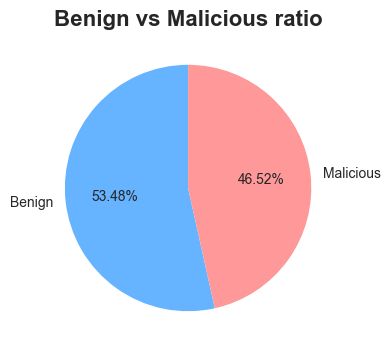

In [20]:
# Create standard label_binary column
data['label_binary'] = data['label'].map({'Benign': 0, 'Malicious': 1})

print("Binary label distribution:")
print(data['label_binary'].value_counts(), "\n======================")
print(data['label_binary'].value_counts(normalize=True))

# Draw beautiful pie charts
plt.figure(figsize=(4,4))
plt.pie(data['label_binary'].value_counts(), 
        labels=['Benign', 'Malicious'], 
        autopct='%1.2f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Benign vs Malicious ratio', fontsize=16, fontweight='bold')
plt.show()

#### 2.2 Time-based analysis (ts)


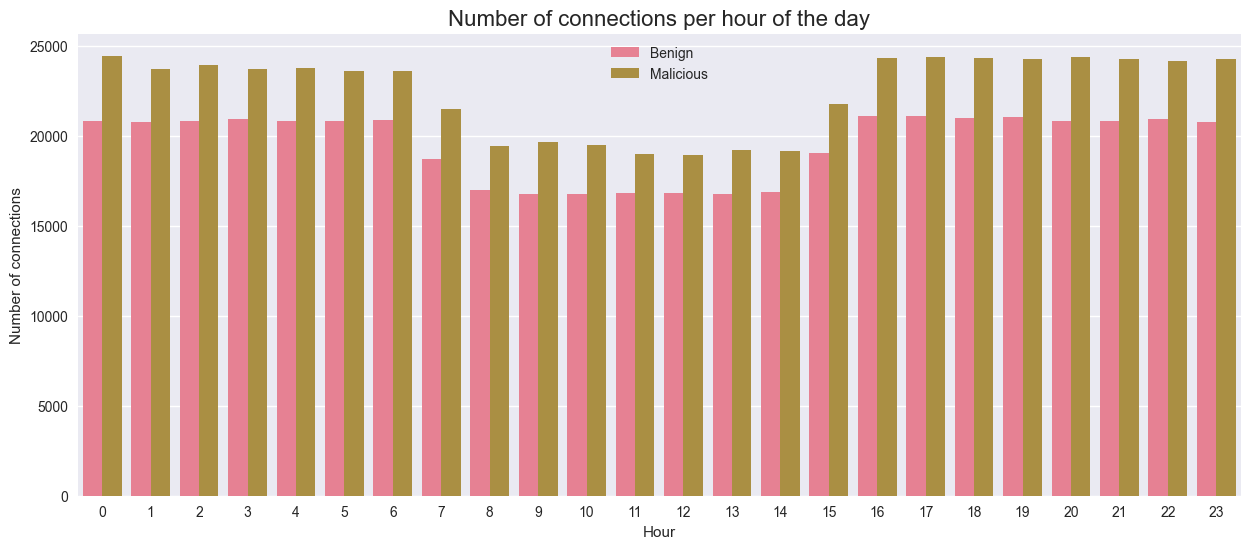

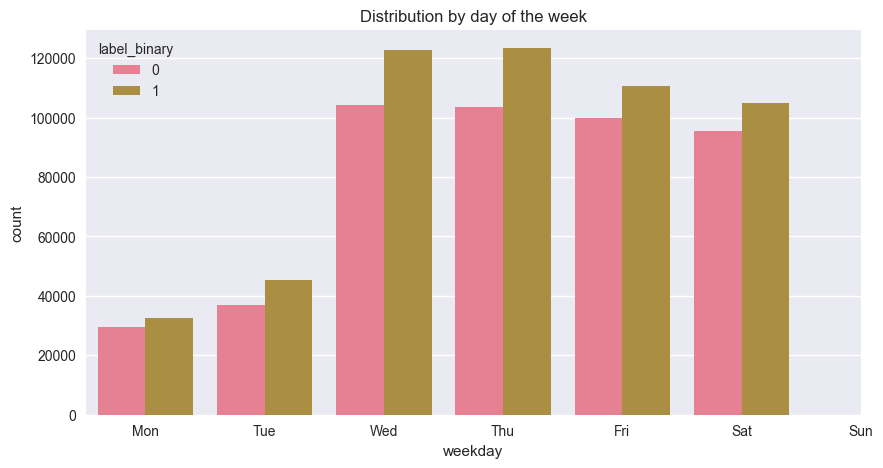

In [21]:
# Convert timestamp
data['datetime'] = pd.to_datetime(data['ts'], unit='s')
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.date
data['weekday'] = data['datetime'].dt.weekday

# Number of connections per hour
plt.figure(figsize=(15,6))
sns.countplot(data=data, x='hour', hue='label_binary')
plt.title('Number of connections per hour of the day', fontsize=16)
plt.xlabel('Hour')
plt.ylabel('Number of connections')
plt.legend(['Benign', 'Malicious'])
plt.show()

# By day of the week week
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='weekday', hue='label_binary')
plt.title('Distribution by day of the week')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()


Malicious (PortScan) often focuses on 16-23h and concentrates on Wednesday and Thursday.


#### 2.3. Protocol & Service

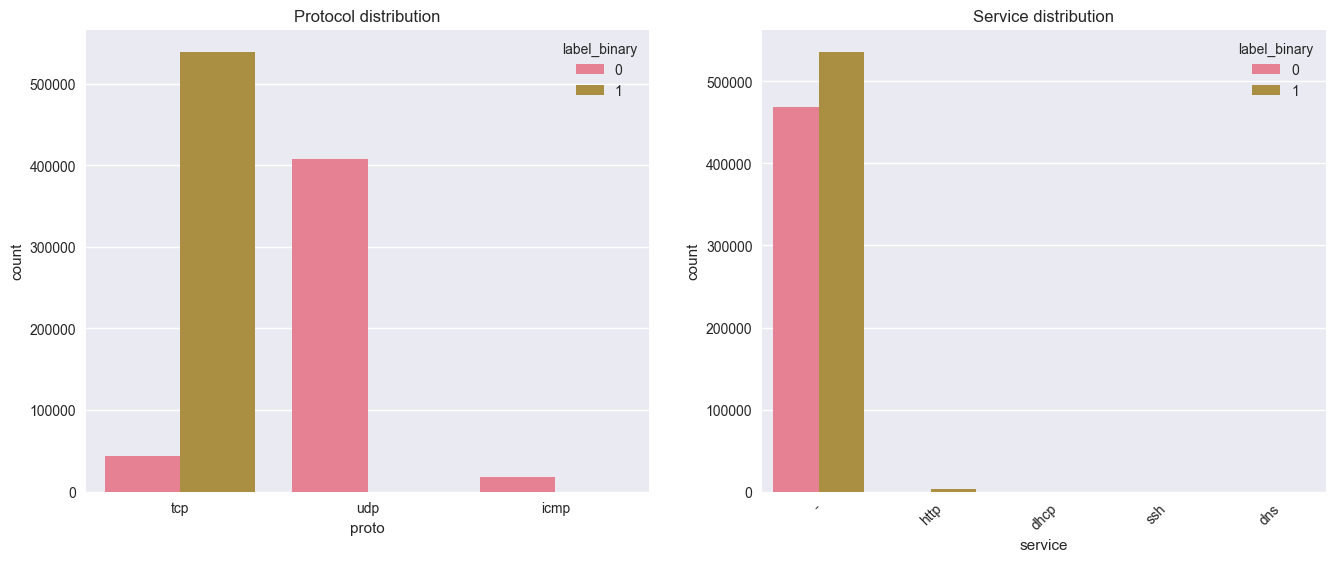

In [22]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.countplot(data=data, x='proto', hue='label_binary', ax=ax[0])
ax[0].set_title('Protocol distribution')

sns.countplot(data=data, x='service', hue='label_binary', ax=ax[1])
ax[1].set_title('Service distribution')
plt.xticks(rotation=45)
plt.show()

#### 2.4. Top destination ports are attacked


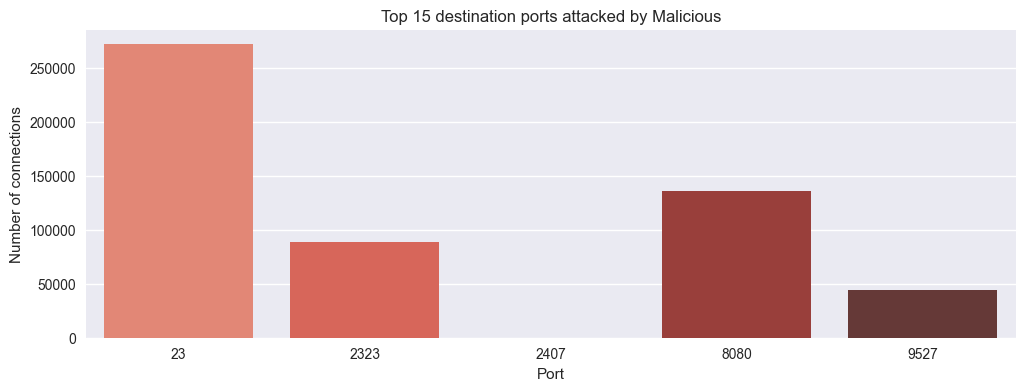

In [23]:
top_ports = data[data['label_binary']==1]['id.resp_p'].value_counts().head(15)

plt.figure(figsize=(12,4))
sns.barplot(x=top_ports.index, y=top_ports.values, palette='Reds_d')
plt.title('Top 15 destination ports attacked by Malicious')
plt.xlabel('Port')
plt.ylabel('Number of connections')
plt.show()

#### 2.5. Distribution of numerical features


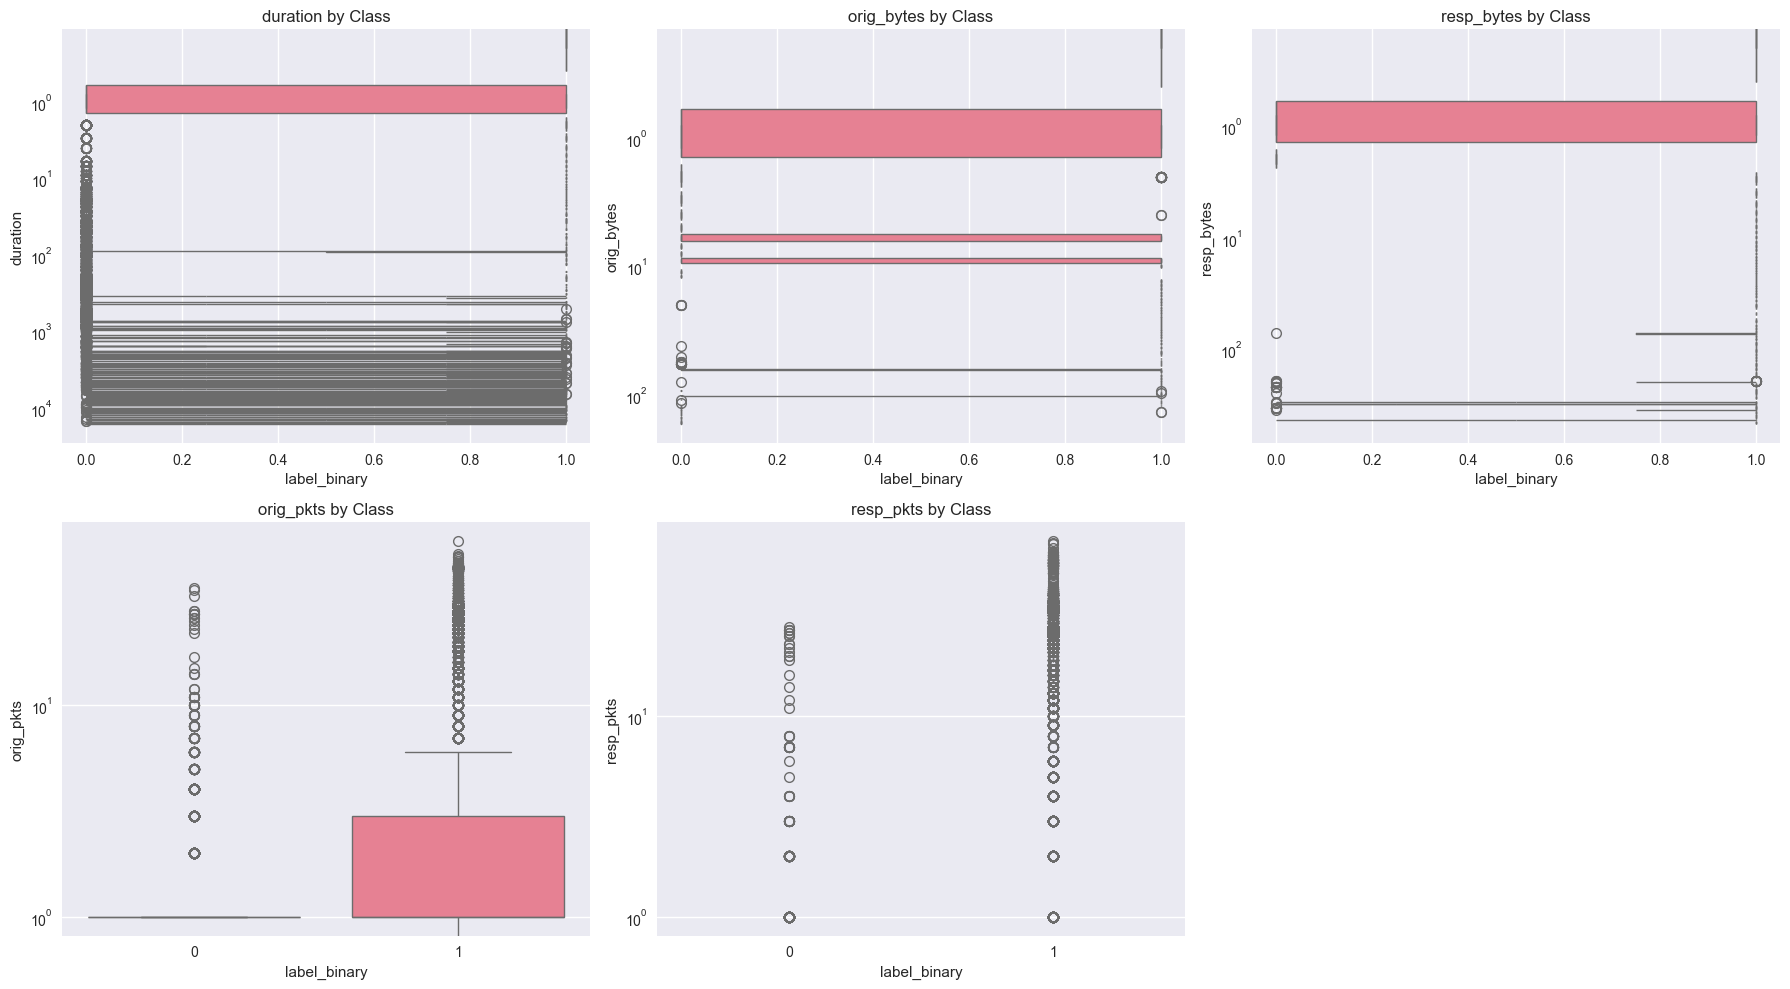

In [24]:
num_features = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts']

fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.ravel()

for i, col in enumerate(num_features):
    sns.boxplot(data=data, x='label_binary', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Class')
    axes[i].set_yscale('log') 

# Hide extra plot
axes[5].axis('off')
plt.tight_layout()
plt.show()

#### 2.6. Correlation heatmap


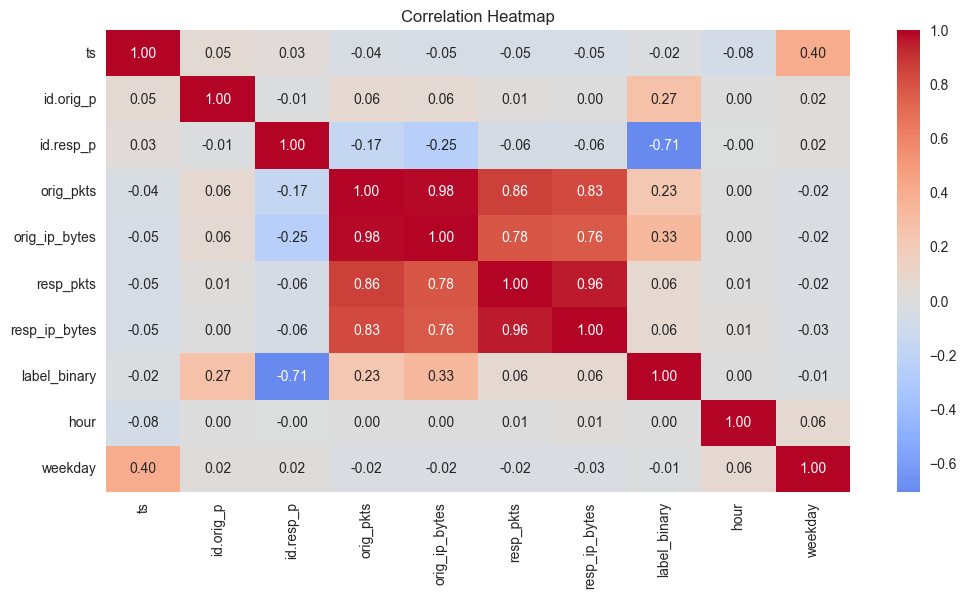

In [25]:
# Get only numeric columns
num_cols = data.select_dtypes(include=[np.number]).columns
corr = data[num_cols].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### 2.7. Scatter plot `orig_bytes` vs `resp_bytes`


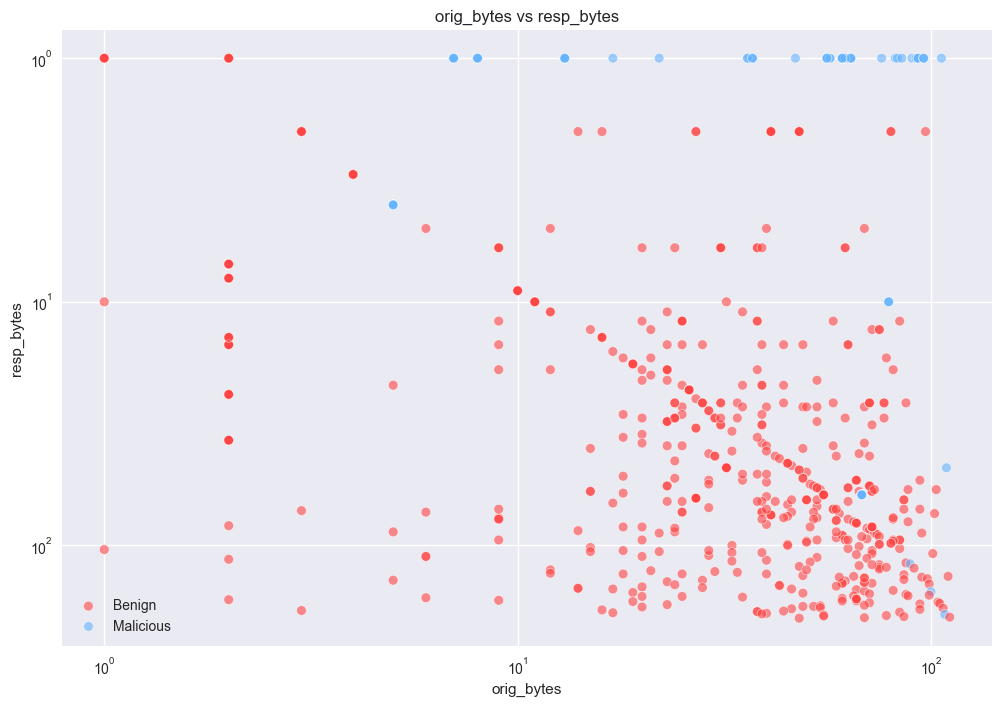

In [26]:
sample = data.sample(frac=0.1, random_state=42)  

plt.figure(figsize=(12,8))
sns.scatterplot(data=sample, x='orig_bytes', y='resp_bytes', 
                hue='label_binary', alpha=0.6, palette=['#66b3ff','#ff4444'])
plt.xscale('log')
plt.yscale('log')
plt.title('orig_bytes vs resp_bytes')
plt.legend(['Benign', 'Malicious'])
plt.show()

##### Key Findings:

##### 1. **The real problem is that binary classification is almost balanced**

- Benign: 53.48%
- Malicious (mainly PartOfAHorizontalPortScan + 8 C&C samples): 46.52%

--> This is one of the rare network datasets with a ratio of nearly 1:1, which helps to significantly reduce the class imbalance problem.

##### 2. **The attack behavior has a very clear time pattern**

- Malicious traffic spikes at certain time frames (especially 0:00–6:00 and 15:00–23:00), while Benign is more evenly distributed.
- Monday has the lowest attack volume, Thursday and Saturday have the highest --> consistent with the botnet's behavior of scanning ports on an automatic schedule.

##### 3. **Extremely strong distinguishing protocol and service characteristics**

- Malicious: almost 100% tcp and udp, very little icmp.
- Benign has the appearance of many real services (http, dhcp, ssh, dns), while Malicious is mostly service = “-” (unknown).

##### 4. **Highly concentrated attack target ports**

Top 5 scanned ports: 23 (Telnet), 2323, 2407, 8080, 9527 --> these are typical ports that Mirai and IoT botnet variants often target.

##### 5. **Extremely clear difference in traffic characteristics**

- Malicious:
  - very short duration (mostly < 1 second)
  - orig_bytes ≈ resp_bytes ≈ a few dozen bytes (scan packets)
  - orig_pkts = resp_pkts = 1 (almost only send 1 packet and receive 1 back)
- Benign:
  - duration is many orders of magnitude longer
  - resp_bytes is significantly larger (there is real feedback from the device)
  - orig_bytes and resp_bytes vary widely

--> Just looking at the scatter plot orig_bytes vs resp_bytes (log-scale) shows that the two clusters are completely separate.

##### 6. **Correlation matrix confirms features with high discriminative power**

- id.resp_p (destination port) has the strongest negative correlation with label (-0.71) --> port is the most important feature.
- The bytes/packets columns are all highly correlated (> 0.8–0.98), indicating that additional ratio features can be created without worrying about too much multicollinearity.


##### Conclusion from EDA:

The data shows that the difference between Benign and Malicious (mainly Horizontal Port Scan) is extremely clear across most feature dimensions. This suggests that even simple models (Decision Tree, Logistic Regression) can achieve very high accuracy, and modern tree-based models (LightGBM, XGBoost, CatBoost) are capable of achieving an `F1-score` > **99.8%** on the test set over time.

##### The purpose of this EDA step:

- Confirm the feasibility and difficulty level of the problem.
- Detect actual patterns of IoT attacks to include in the Discussion section.
- Serve as a basis for selecting and creating physically meaningful features in the next Feature Engineering step.


### III. Feature Engineering


**Purpose**: Create new features based on EDA findings to enhance model performance


In [27]:
df = data.copy()

In [28]:
df.head()
df.columns


Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'label', 'detailed_label', 'label_binary', 'datetime',
       'hour', 'day', 'weekday'],
      dtype='object')

#### **3.1 Time-based features**

In [29]:
# Reason: IoT botnets often scan at specific times (night, weekends, fixed intervals)
df['datetime'] = pd.to_datetime(df['ts'], unit='s')

df['hour']          = df['datetime'].dt.hour
df['is_night']      = df['hour'].isin([0,1,2,3,4,5,22,23]).astype(int)   # 22h–5h
df['is_weekend']    = df['datetime'].dt.weekday.isin([5,6]).astype(int)
df['sin_hour']      = np.sin(2 * np.pi * df['hour'] / 24)                # Cyclic encoding
df['cos_hour']      = np.cos(2 * np.pi * df['hour'] / 24)

#### **3.2 Duration features**

In [30]:
# Reason: Port scans have extremely short flows, normal IoT traffic is longer
df['duration'] = df['duration'].replace('-', np.nan).astype(float).fillna(0)

df['log_duration']     = np.log1p(df['duration'])          # Heavy right-skew --> log
df['is_short_flow']    = (df['duration'] < 1.0).astype(int)   # <1s --> typical scan
df['is_long_flow']     = (df['duration'] > 30.0).astype(int)  # >30s --> normal session

#### **3.3 Byte & packet basic features (cast to numeric safely)**

In [31]:
byte_pkt_cols = ['orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts',
                 'orig_ip_bytes', 'resp_ip_bytes']

for col in byte_pkt_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

#### **3.4 Ratio & per-second features (extremely powerful for scan detection)**


In [32]:
epsilon = 1e-6

df['bytes_per_pkt_orig']   = df['orig_bytes'] / (df['orig_pkts'] + epsilon)
df['bytes_per_pkt_resp']   = df['resp_bytes'] / (df['resp_pkts'] + epsilon)

df['pkts_per_second']      = (df['orig_pkts'] + df['resp_pkts']) / (df['duration'] + epsilon)
df['bytes_per_second']     = (df['orig_bytes'] + df['resp_bytes']) / (df['duration'] + epsilon)

df['ratio_orig_resp_bytes']= df['orig_bytes'] / (df['resp_bytes'] + epsilon)
df['ratio_resp_orig_bytes']= df['resp_bytes'] / (df['orig_bytes'] + epsilon)

# Very strong indicator: scans usually have almost no response bytes
df['response_ratio']       = df['resp_bytes'] / (df['orig_bytes'] + df['resp_bytes'] + epsilon)

#### **3.5 Port features – destination port is the #1 discriminator in this dataset**

In [33]:
df['id.resp_p'] = df['id.resp_p'].astype(int)

# Well-known vulnerable IoT ports used by Mirai-like bots
mirai_ports = [23, 2323, 48101, 37215, 9527, 2407, 8080, 80, 443]
df['is_mirai_port'] = df['id.resp_p'].isin(mirai_ports).astype(int)

# Port 0 is used in ICMP scans
df['is_port_zero'] = (df['id.resp_p'] == 0).astype(int)

# High ports (>49152) are rare in normal IoT traffic
df['is_high_port'] = (df['id.resp_p'] > 49152).astype(int)

#### **3.6 Protocol & Service encoding (one-hot + target encoding hybrid)**


In [34]:
df = pd.get_dummies(df, columns=['proto'], prefix='proto', drop_first=True)

# Service has many "-" --> treat as missing and add an indicator
df['service_missing'] = (df['service'] == '-').astype(int)
df['service'] = df['service'].replace('-', 'None')
df = pd.get_dummies(df, columns=['service'], prefix='svc')

#### **3.7 Conn_state & History flags**

In [35]:
# conn_state: one-hot (few unique values)
df = pd.get_dummies(df, columns=['conn_state'], prefix='state', drop_first=True)

# History string --> extract meaningful flags
df['history_len'] = df['history'].str.len()

# Common flags in scans
df['has_S'] = df['history'].str.contains('S', na=False).astype(int)   # SYN
df['has_A'] = df['history'].str.contains('A', na=False).astype(int)   # ACK
df['has_F'] = df['history'].str.contains('F', na=False).astype(int)   # FIN
df['has_R'] = df['history'].str.contains('R', na=False).astype(int)   # RST
df['has_D'] = df['history'].str.contains('D', na=False).astype(int)   # Data
df['syn_only'] = ((df['history'] == 'S') | (df['history'] == '^S')).astype(int)

#### **3.8 IP-related features (source IP behavior)**

In [36]:
# Number of flows from same source IP (proxy for scanning behavior)
ip_counts = df['id.orig_h'].value_counts()
df['src_ip_flow_count'] = df['id.orig_h'].map(ip_counts)

# Very high flow count from one IP --> typical scanner
df['is_scanner_ip'] = (df['src_ip_flow_count'] > 1000).astype(int)

#### **3.9 Final feature list for modeling (drop non-numeric / redundant columns)**


In [39]:
drop_cols = ['ts', 'uid', 'id.orig_h', 'id.resp_h', 'datetime', 'history', 'detailed_label']
df_model = df.drop(columns=drop_cols)

print(f"Shape before FE: {data.shape[1]} --> after FE: {df_model.shape[1]}")

Shape before FE: 24 --> after FE: 58


In [38]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,history,...,state_SH,history_len,has_S,has_A,has_F,has_R,has_D,syn_only,src_ip_flow_count,is_scanner_ip
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,2.999051,0.0,0.0,S,...,False,1,1,0,0,0,0,1,991061,1
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,0.000000,0.0,0.0,S,...,False,1,1,0,0,0,0,1,991061,1
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,0.000000,0.0,0.0,S,...,False,1,1,0,0,0,0,1,991061,1
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,2.998796,0.0,0.0,S,...,False,1,1,0,0,0,0,1,991061,1
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,0.000000,0.0,0.0,S,...,False,1,1,0,0,0,0,1,991061,1
